#Intersection over Union (IoU)
IoU is a metric used in computer vision to measure the accuracy of an object detector on a particular dataset. It is defined as the area of overlap between the predicted bounding box and the ground truth bounding box, divided by the area of union of these two boxes:

IoU = Area of Overlap / Area of Union

In [1]:
#Implementation from:
#https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/

def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1

    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou

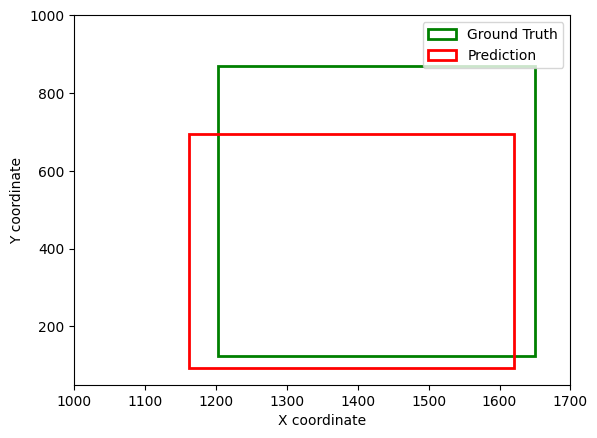

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ground_truth_bbox = np.array([1202, 123, 1650, 868], dtype=np.float32)
prediction_bbox = np.array([1162.0001, 92.0021, 1619.9832, 694.0033], dtype=np.float32)

fig, ax = plt.subplots(1)

ground_truth_rect = patches.Rectangle((ground_truth_bbox[0], ground_truth_bbox[1]),
                                      ground_truth_bbox[2] - ground_truth_bbox[0],
                                      ground_truth_bbox[3] - ground_truth_bbox[1],
                                      linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
ax.add_patch(ground_truth_rect)

prediction_rect = patches.Rectangle((prediction_bbox[0], prediction_bbox[1]),
                                    prediction_bbox[2] - prediction_bbox[0],
                                    prediction_bbox[3] - prediction_bbox[1],
                                    linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
ax.add_patch(prediction_rect)


ax.set_xlim(1000, 1700)
ax.set_ylim(50, 1000)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()

plt.show()

In [3]:
iou = get_iou(ground_truth_bbox, prediction_bbox)
print('IOU: ', iou)

IOU:  0.6441399913136432


#Generalized Intersection over Union (GIoU)

GIoU is an extension of the IoU metric, designed to offer a more accurate measure of the spatial relationship between two bounding boxes. It takes into account the cases where IoU is 0 (non-overlapping bounding boxes). GIoU is defined as:

GIoU = IoU - (Area of the Smallest Enclosing Box - Area of Union) / Area of the Smallest Enclosing Box

In [4]:
# Implementation from: https://github.com/facebookresearch/fvcore/blob/bfff2ef/fvcore/nn/giou_loss.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.

import torch


def giou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: str = "none",
    eps: float = 1e-7,
) -> torch.Tensor:
    """
    Generalized Intersection over Union Loss (Hamid Rezatofighi et. al)
    https://arxiv.org/abs/1902.09630

    Gradient-friendly IoU loss with an additional penalty that is non-zero when the
    boxes do not overlap and scales with the size of their smallest enclosing box.
    This loss is symmetric, so the boxes1 and boxes2 arguments are interchangeable.

    Args:
        boxes1, boxes2 (Tensor): box locations in XYXY format, shape (N, 4) or (4,).
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
        eps (float): small number to prevent division by zero
    """

    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    assert (x2 >= x1).all(), "bad box: x1 larger than x2"
    assert (y2 >= y1).all(), "bad box: y1 larger than y2"

    # Intersection keypoints
    xkis1 = torch.max(x1, x1g)
    ykis1 = torch.max(y1, y1g)
    xkis2 = torch.min(x2, x2g)
    ykis2 = torch.min(y2, y2g)

    intsctk = torch.zeros_like(x1)
    mask = (ykis2 > ykis1) & (xkis2 > xkis1)
    intsctk[mask] = (xkis2[mask] - xkis1[mask]) * (ykis2[mask] - ykis1[mask])
    unionk = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - intsctk
    iouk = intsctk / (unionk + eps)

    # smallest enclosing box
    xc1 = torch.min(x1, x1g)
    yc1 = torch.min(y1, y1g)
    xc2 = torch.max(x2, x2g)
    yc2 = torch.max(y2, y2g)

    area_c = (xc2 - xc1) * (yc2 - yc1)
    miouk = iouk - ((area_c - unionk) / (area_c + eps))

    loss = 1 - miouk

    if reduction == "mean":
        loss = loss.mean() if loss.numel() > 0 else 0.0 * loss.sum()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

#References

Generalized Intersection over Union. A Metric and A Loss for Bounding Box Regression [chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://giou.stanford.edu/GIoU.pdf]